# Preparing Data

In [ ]:
# Installing necessary libraries 
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install networkx
# !pip install powerlaw
# !pip install graphistry

In [83]:
# Importing necessary libraries
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
import seaborn as sns
import graphistry

The following code block loads the Boxofficemojo dataset, removes movies where there is no worldwide box office data, convert runtime to integers, converts release date to "xx-xx-xxxx" format and initializes the graph nodes  

In [84]:
movies = pd.read_csv(r'data\Kaggle\Mojo_budget_update.csv\Mojo_budget_update.csv')
# remove a column mpaa
movies = movies.drop(columns=['mpaa'])
# remove rows with nan in worldwide and in budget
movies = movies.dropna(subset=["worldwide"])
# movies = movies.dropna(subset=["budget"])
# fill nan with unknown
movies = movies.fillna("UNKNOWN",)
# number of nan in each column 
# {'mpaa': 161, 'release_date': 1, 'distributor': 15, 'writer': 9, 'producer': 13, 'composer': 105, 'cinematographer': 114, 
# 'main_actor_4': 3, 'domestic': 19, 'international': 410, 'worldwide': 7, 'genre_2': 281, 'genre_3': 1022, 'genre_4': 2120}

#Make a graph
movie_graph = nx.Graph()
movie_graph.add_nodes_from(movies['title'])
# reformat the date
def getDate(year,date):
    dict_months = {'January':"1", 'February':"2", 'March':"3", 'April':"4", 'May':"5", 'June':"6", 'July':"7", 'August':"8", 'September':"9", 'October':"10", 'November':"11", 'December':"12"}
    try:
        date = date.split()
    except:
        date = ['January','1']
    year = str(year)
    date = str(date[1]) + '-' + dict_months[date[0]] + '-' + year
    return date
# reformat the run time
def getRunTime(run_time):
    try:
        run_time = run_time.split()
        run_time = int(run_time[0]) * 60 + int(run_time[2])
    except:
        run_time = "UNKNOWN"
    return run_time

# add attributes to the nodes#mpaa is after the release year
for node in movie_graph.nodes:
    row = movies.loc[movies['title'] == node]
    movie_id, _,release_year,_,release_date, run_time, distributor, director, writer, producer, composer, cinematographer, \
    main_actor_1, main_actor_2, main_actor_3, main_actor_4, budget, domestic, international, worldwide, \
    genre_1, genre_2, genre_3, genre_4, link = row.iloc[0, :].values

    release_date = getDate(release_year, release_date)
    run_time = getRunTime(run_time)
    actors = [main_actor_1, main_actor_2, main_actor_3, main_actor_4]
    genres = [genre_1, genre_2, genre_3, genre_4]
    
    movie_graph.nodes[node]['movie_id'] = movie_id
    movie_graph.nodes[node]['release_year'] = release_year
    movie_graph.nodes[node]['release_date'] = release_date
    movie_graph.nodes[node]['run_time'] = run_time
    movie_graph.nodes[node]['distributor'] = distributor
    movie_graph.nodes[node]['director'] = director
    movie_graph.nodes[node]['writer'] = writer
    movie_graph.nodes[node]['producer'] = producer
    movie_graph.nodes[node]['composer'] = composer
    movie_graph.nodes[node]['cinematographer'] = cinematographer
    movie_graph.nodes[node]['actors'] = actors
    movie_graph.nodes[node]['budget'] = budget
    movie_graph.nodes[node]['domestic'] = domestic
    movie_graph.nodes[node]['international'] = international
    movie_graph.nodes[node]['worldwide'] = worldwide
    movie_graph.nodes[node]['genres'] = genres
    movie_graph.nodes[node]['link'] = link


In [85]:
print("Number of nodes", len(movie_graph.nodes)) 
print("Number of unique distributor", len(movies["distributor"].unique()))
# print("precentag of movies per distributor" , movies["distributor"].value_counts())
print(f"Budget Stats \n mean is {round(movies["budget"].mean())}, midian is {movies["budget"].median()}, standard deviation budget is { round(movies["budget"].std())}")
print(f"worldwide Stats \n mean is {round(movies["worldwide"].mean())}, midian is {movies['worldwide'].median()}, standard deviation worldwide is { round(movies['worldwide'].std())}")
print("Number of unique genres", len(movies["genre_1"].unique()))
print("Number of unique actors", len((movies["main_actor_1"]+movies["main_actor_2"]+movies["main_actor_3"]+movies["main_actor_4"]).unique()))
print(f"Number of unique directors {len(movies['director'].unique())} writers {len(movies['writer'].unique())} and producers {len(movies['producer'].unique())} and composers {len(movies['composer'].unique())} and cinematographers {len(movies['cinematographer'].unique())}")
print(f"Earnings Stats \n mean is {round(movies['worldwide'].mean())-round(movies['budget'].mean())}, midian is {movies['worldwide'].median()-movies['budget'].median()}")
print("biggest Winner is ", movies.loc[(movies['worldwide']-movies['budget']).idxmax()]['title'])
print("biggest Loser is ", movies.loc[(movies['worldwide']-movies['budget']).idxmin()]['title'])
# print("Movies released per year", movies['year'].value_counts(ascending=True))

Number of nodes 3208
Number of unique distributor 197
Budget Stats 
 mean is 46308759, midian is 30000000.0, standard deviation budget is 47097816
worldwide Stats 
 mean is 139312154, midian is 62251587.5, standard deviation worldwide is 216210703
Number of unique genres 15
Number of unique actors 3212
Number of unique directors 1520 writers 2103 and producers 1539 and composers 792 and cinematographers 854
Earnings Stats 
 mean is 93003395, midian is 32251587.5
biggest Winner is  Avatar
biggest Loser is  Mars Needs Moms


In [86]:
movies[movies['title'] == 'The Matrix']

,movie_id,title,year,trivia,release_date,run_time,distributor,director,writer,producer,...,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
464,tt0133093,The Matrix,1999,A computer hacker learns from mysterious rebel...,March 31,2 hr 16 min,Warner Bros.,Lana Wachowski,Lilly Wachowski,Joel Silver,...,Hugo Weaving,63000000.0,171479930.0,293863857.0,465343787.0,Action,Sci-Fi,UNKNOWN,UNKNOWN,https://www.boxofficemojo.com/title/tt0133093/...


The following code block does:
* Reads the Rotten Tomatoes reviews dataset
* keeps the movie id, reviewid, and review text
* drop rows that holds no review text
* Reads the Rotten Tomatoes movies dataset (where it  holds information about the movies)
* Joins the 2 data sets into a `merged_reviews` data sets that now holds id, reviewId, reviewText and movie title

In [87]:
reviews = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movie_reviews.csv')
reviews_head = reviews.head()
reviews=reviews[["id","reviewId","reviewText"]]
reviews = reviews.dropna(subset=["reviewText"])
RT_movies = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movies.csv')
RT_movies=RT_movies[["id","title"]]
merged_reviews = pd.merge(RT_movies, reviews, on='id')
merged_reviews = pd.merge(merged_reviews, movies[['title']], left_on='title', right_on='title')

Add the reviews of the movies in nodes

In [88]:
dicReviews = {}
for index, row in merged_reviews.iterrows():
    if row['title'] in movie_graph.nodes:
        if row['title'] not in dicReviews:
            dicReviews[row['title']] = []
        dicReviews[row['title']].append(row['reviewText'])
print("Number of movies with reviews", len(dicReviews))
print("total number of reviews", len([j for i in dicReviews.values() for j in i]))

for node in movie_graph.nodes:
    if node in dicReviews:
        movie_graph.nodes[node]['reviews'] = dicReviews[node]

Number of movies with reviews 2932
total number of reviews 429696


This block adjusts the monetary values for inflation

In [89]:
import cpi
##  budget domestic  international worldwide 
for node in movie_graph.nodes:
    movie_graph.nodes[node]['budget'] = cpi.inflate(int(movie_graph.nodes[node]['budget']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['domestic'] != "UNKNOWN":
        movie_graph.nodes[node]['domestic'] = cpi.inflate(int(movie_graph.nodes[node]['domestic']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['international'] != "UNKNOWN":
        movie_graph.nodes[node]['international'] = cpi.inflate(int(movie_graph.nodes[node]['international']), movie_graph.nodes[node]['release_year'])
    movie_graph.nodes[node]['profit'] = movie_graph.nodes[node]['worldwide'] - movie_graph.nodes[node]['budget']

In [90]:
print("number of movies with reviews", len(merged_reviews['title'].unique()))
print("number of reviews", len(merged_reviews['reviewId'].unique()))
print("number of reviews per movie", merged_reviews['title'].value_counts(ascending=False))
print(f"mean number of reviews per movie {merged_reviews['title'].value_counts().mean()} median {merged_reviews['title'].value_counts().median()}")
print("number of movies with more than 50 reviews", len(merged_reviews['title'].value_counts()[merged_reviews['title'].value_counts()>50]))
print(f"The mean length of reviews is {merged_reviews['reviewText'].apply(len).mean()} and the median is {merged_reviews['reviewText'].apply(len).median()}")
print(f"The mean number of words in reviews is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).mean()} and the median is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).median()}")

number of movies with reviews 2932
number of reviews 413562
number of reviews per movie title
Parasite                1921
Beauty and the Beast    1168
The Lion King           1122
Godzilla                1084
Little Women            1038
                        ... 
The Lorax                  1
Royal Kill                 1
A Long Way Off             1
Beat the Drum              1
Alone Yet Not Alone        1
Name: count, Length: 2932, dtype: int64
mean number of reviews per movie 146.55388813096863 median 130.0
number of movies with more than 50 reviews 2448
The mean length of reviews is 127.99440301980935 and the median is 127.0
The mean number of words in reviews is 21.466581024724455 and the median is 21.0


Remove movies with no reviews

In [91]:
# Get a set of movie titles that have reviews
reviewed_movies = set(merged_reviews['title'])

# Identify nodes in the graph that do not have reviews
nodes_to_remove = [node for node in movie_graph.nodes if node not in reviewed_movies]

# Remove those nodes from the graph
movie_graph.remove_nodes_from(nodes_to_remove)

In [92]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 2932


Add edges to the graph based on actors, if to movies share at least one actor there will be edge between them. 

In [93]:
# list of movies for each actor
actor_to_movies = defaultdict(set)

for movie in movie_graph.nodes:
    actors = movie_graph.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)


In [94]:
# Add edges between movies that share an actor
for actor, movies in actor_to_movies.items():
    movie_list = list(movies)
    for i in range(len(movie_list)):
        for j in range(i + 1, len(movie_list)):
            movie_graph.add_edge(movie_list[i], movie_list[j], actor=actor)

In [95]:
print(f"Number of nodes: {movie_graph.number_of_nodes()}")
print(f"Number of edges: {movie_graph.number_of_edges()}")

Number of nodes: 2932
Number of edges: 37774


Delete isolated nodes

In [96]:
# Remove isolated nodes
isolated_nodes = [node for node, degree in dict(movie_graph.degree()).items() if degree == 0]

graph_no_isolated = movie_graph.copy()
graph_no_isolated.remove_nodes_from(isolated_nodes)

In [97]:
print(f"Number of nodes in main graph: {movie_graph.number_of_nodes()}")
print(f"Number of edges in main graph: {movie_graph.number_of_edges()}")

print(f"\nNumber of nodes without isolated: {graph_no_isolated.number_of_nodes()}")
print(f"Number of edges without isolated: {graph_no_isolated.number_of_edges()}")

Number of nodes in main graph: 2932
Number of edges in main graph: 37774

Number of nodes without isolated: 2799
Number of edges without isolated: 37774


Extract the largest component

In [98]:
# Extract the largest connected component
largest_component = max(nx.connected_components(graph_no_isolated), key=len)
graph_largest = graph_no_isolated.subgraph(largest_component).copy()

print(f"Number of nodes in largest_component: {graph_largest.number_of_nodes()}")
print(f"Number of edges in largest_component: {graph_largest.number_of_edges()}")

Number of nodes in largest_component: 2777
Number of edges in largest_component: 37758


### Degree distribution

In [99]:
# Get degree distribution
degree_sequence = sorted([d for n, d in movie_graph.degree()], reverse=True)  # Sorted list of degrees
degree_count = np.bincount(degree_sequence)  # Count occurrences of each degree
degrees = np.arange(len(degree_count)) 

# Check for hubs in the network
max_degree = max(degree_sequence)
average_degree = np.mean(degree_sequence)
print("Maximum degree:", max_degree)
print("Average degree:", average_degree)

Maximum degree: 91
Average degree: 25.766712141882675


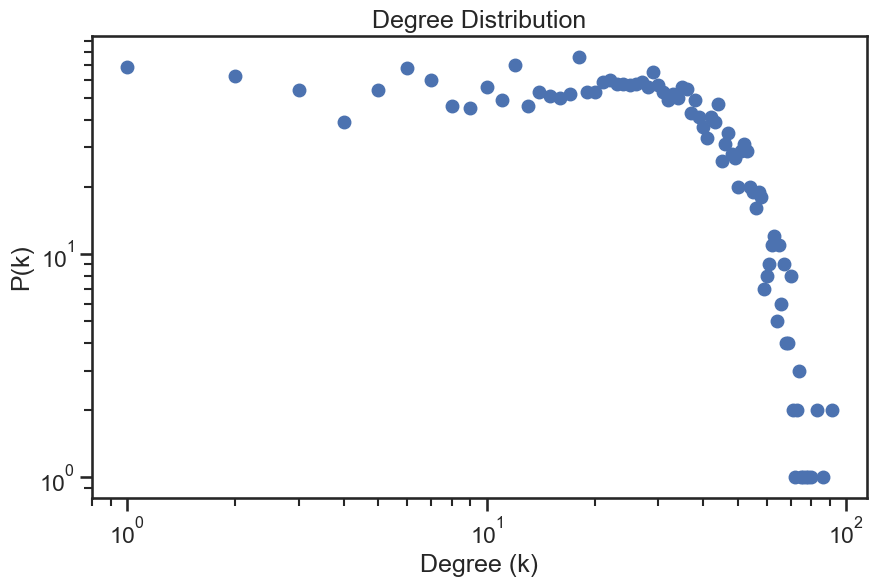

In [100]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution")
plt.show()

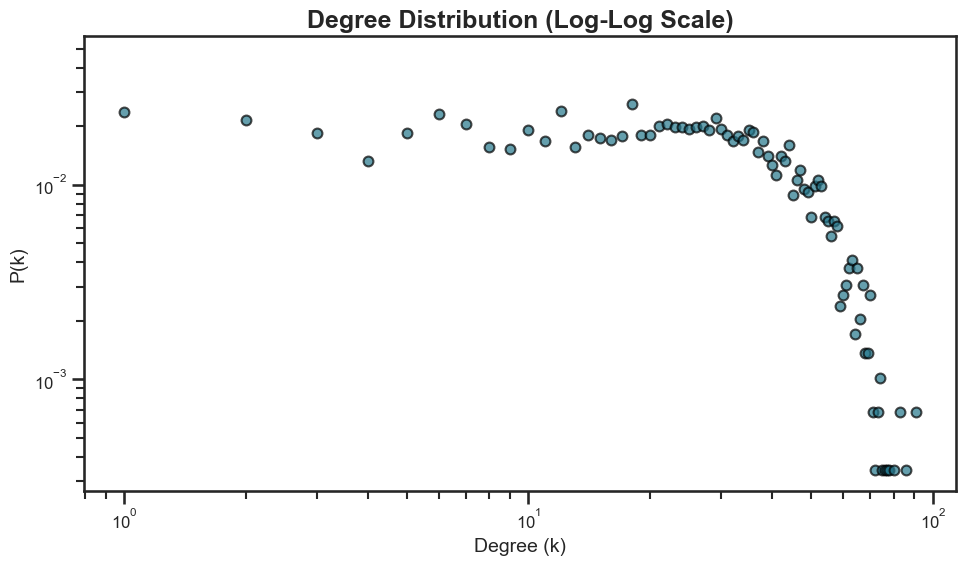

In [101]:
def plot_log_log_degree_dist(
    G, 
    filename="log_log_degree_distribution.png", 
    ref_alpha=None, 
    ref_xmin=None
):
    # Extract degrees of nodes
    degrees = [G.degree(n) for n in G.nodes()]
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    
    # Compute P(k) = counts / total number of nodes
    pk = counts / len(degrees)
    
    # Set up Seaborn style
    sns.set(style="ticks", context="talk")  # Use "ticks" style for minimal grid
    palette = sns.color_palette("crest", as_cmap=True)  # New colormap
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for P(k) vs k
    plt.scatter(
        unique_degrees, 
        pk, 
        color=palette(0.6),  # Pick a distinct color
        alpha=0.7, 
        s=50, 
        edgecolor="black", 
        label="Observed P(k)"
    )
    
    # Add a reference power-law line if specified
    if ref_alpha is not None and ref_xmin is not None:
        x_ref = np.array(sorted(unique_degrees[unique_degrees >= ref_xmin]))
        y_ref = (x_ref ** (-ref_alpha)) / np.sum(x_ref ** (-ref_alpha))
        plt.plot(
            x_ref, y_ref, 
            linestyle="--", color="red", linewidth=2, 
            label=f"Power-law fit (α={ref_alpha:.2f}, xmin={ref_xmin})"
        )
    
    # Add title and labels
    plt.title("Degree Distribution (Log-Log Scale)", fontsize=18, weight='bold')
    plt.xlabel("Degree (k)", fontsize=14)
    plt.ylabel("P(k)", fontsize=14)
    
    # Log-log scale
    plt.xscale("log")
    plt.yscale("log")
    
    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot to a file
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')  # Save with high resolution
    
    # Show the plot
    plt.show()

plot_log_log_degree_dist(movie_graph)

### Is our network scale-free?

In [102]:
# Fit the degree sequence to a power law
fit = powerlaw.Fit(degree_sequence)

# Check the power law exponent
print("Power law alpha:", fit.power_law.alpha)
print("xmin for power law fit:", fit.power_law.xmin)

# Compare power-law fit with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print("Likelihood ratio R:", R)
print("p-value:", p)

# Interpretation: 
# - If R > 0 and p < 0.05, the power-law fit is significantly better than the exponential fit, 
#   suggesting the network is likely scale-free.

Calculating best minimal value for power law fit
Power law alpha: 14.108294576605937
xmin for power law fit: 65.0
Likelihood ratio R: 0.538158801531007
p-value: 0.2599068976144647


Values less than or equal to 0 in data. Throwing out 0 or negative values


## Plot the base network

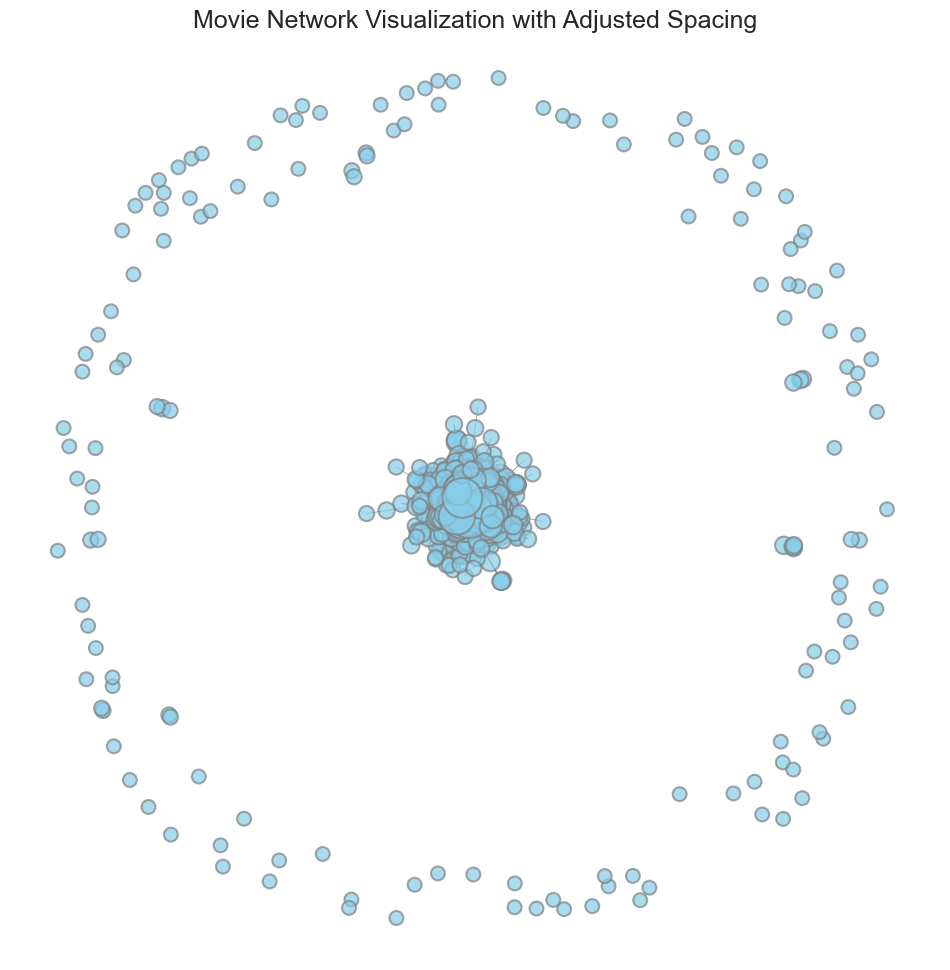

In [103]:
# Calculate node sizes based on degree
node_sizes = [100 + 20 * movie_graph.degree(node) for node in movie_graph.nodes]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(movie_graph, seed=42)

# Draw nodes with varying size
nx.draw_networkx_nodes(movie_graph, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# Draw edges
nx.draw_networkx_edges(movie_graph, pos, width=0.5, alpha=0.5)

plt.title("Movie Network Visualization with Adjusted Spacing")
plt.axis("off")
plt.show()


## Plot the extracted largest component

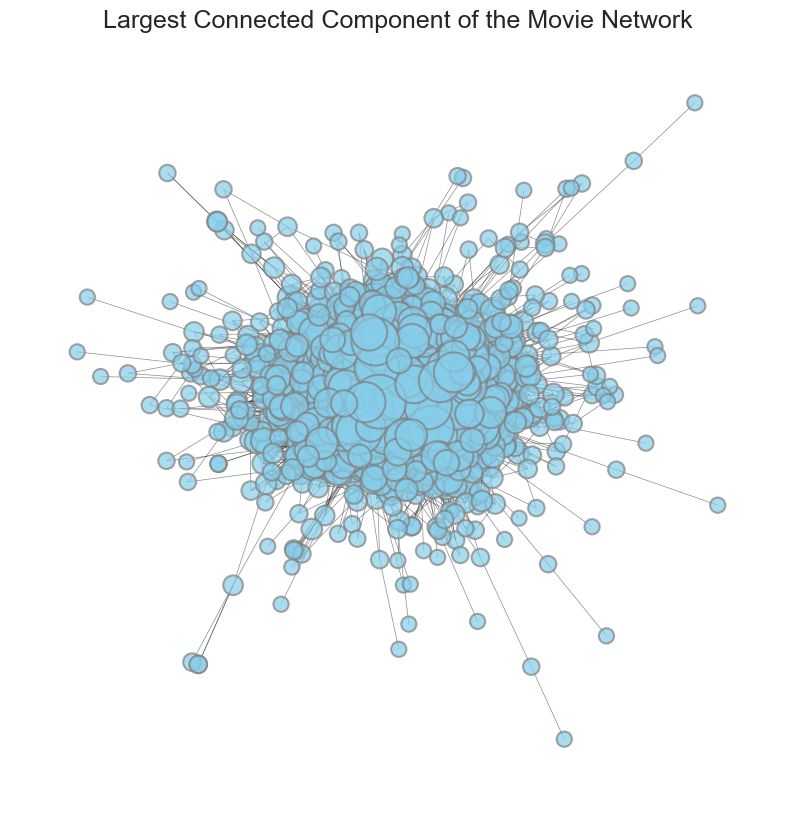

In [104]:
# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# Draw edges
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

plt.title("Largest Connected Component of the Movie Network")
plt.axis("off")
plt.show()


### Kamada layout   

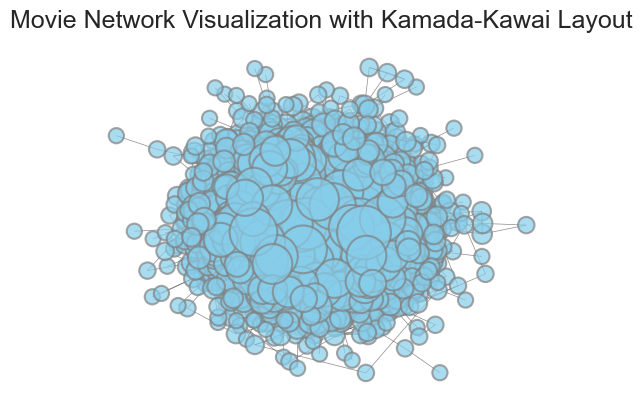

In [105]:
# Use Kamada-Kawai layout instead
pos = nx.kamada_kawai_layout(graph_largest)

nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)
plt.title("Movie Network Visualization with Kamada-Kawai Layout")
plt.axis("off")
plt.show()


### Network Visualisation

In [108]:
initial_pos = {n: np.random.rand(2) for n in movie_graph.nodes}
pos = nx.spring_layout(movie_graph, k=2.0, iterations=50, pos=initial_pos)

# Node DataFrame, including 'actors' attribute
nodes_df = pd.DataFrame.from_dict(dict(movie_graph.nodes(data=True)), orient='index')
nodes_df['degree'] = [movie_graph.degree[node] for node in movie_graph.nodes]
nodes_df['x'] = [pos[node][0] for node in movie_graph.nodes]
nodes_df['y'] =  [pos[node][1] for node in movie_graph.nodes]

# Edge DataFrame
edges_df = nx.to_pandas_edgelist(movie_graph)
edges_df['source'] = edges_df['source'].astype(str)
edges_df['target'] = edges_df['target'].astype(str)

# Make the plot in the visualisation undirected
edges_df['edge'] = edges_df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)
undirected_edges_df = edges_df.drop_duplicates(subset='edge').drop(columns='edge').reset_index(drop=True)

# Replace non-numeric values with NaN and convert column to numeric
nodes_df['domestic'] = pd.to_numeric(nodes_df['domestic'], errors='coerce')
nodes_df['international'] = pd.to_numeric(nodes_df['international'], errors='coerce')
nodes_df["run_time"] = pd.to_numeric(nodes_df["run_time"], errors='coerce')

In [109]:
# Bind the nodes and edges to Graphistry, specifying the source, destination, and node key
# Set up Graphistry (replace with your credentials or use environment variables)
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="michalis", password="FDKeHQR4EQg7pvb")

graph = graphistry.bind(source="source", destination="target", point_x="x", point_y="y") \
                 .edges(undirected_edges_df) \
                 .nodes(nodes_df.reset_index(), node="index") \
                 .encode_point_size("degree") 

graph.plot()

Failed memoization speedup attempt due to Pandas internal hash function failing. Continuing without memoization speedups.This is fine, but for speedups around skipping re-uploads of previously seen tables, try identifying which columns have types that Pandas cannot hash, and convert them to hashable types like strings.